# AWS Athena Queries for S3 Data Access Metrics

This notebook runs queries on S3 access logs to deliver metrics on data usage from s3://nasa-maap-data-store, the primary MAAP data store bucket.

Pre-requisites:
* S3 Access Logs have been enabled and are being delivered to a bucket 
* A database already exists in Athena which parses logs delivered to that bucket
* Queries have been developed and saved in Athena

In [1]:
import boto3
import matplotlib.pyplot as plt
import pandas
import time

In [2]:
# Must run this with MAAP MCP Ops AWS credentials set in your environment
client = boto3.client('athena')

In [8]:
def start_query(query_id):
    response = client.batch_get_named_query(
        NamedQueryIds=[
            # NASA MAAP Requests for BytesByCollection since October 2022
            query_id,
        ]
    )
    query_string = response['NamedQueries'][0]['QueryString']
    print(f"Starting query {query_string}")
    response = client.start_query_execution(QueryString=query_string)
    query_execution_id = response['QueryExecutionId']
    return query_execution_id

def wait_for_finished(query_execution_id):
    state = 'RUNNING'
    status = None
    while state == 'RUNNING':
        status = client.get_query_execution(
            QueryExecutionId=query_execution_id
        )
        state = status['QueryExecution']['Status']['State']
        if state == 'RUNNING':
            time.sleep(5)
    return status

def get_execution_results(query_execution_id):
    # Could use https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena/paginator/GetQueryResults.html
    # to paginate, however we only want top results.
    results = client.get_query_results(
        QueryExecutionId=query_execution_id,
        MaxResults=500
    )
    return results

def create_resutlts_dataframe(results_response):
    top_results_cap = 25
    results_list = []
    # skip the first row which is the header
    for result in results_response['ResultSet']['Rows'][1:]:
        if len(results_list) == top_results_cap:
            break
        collection = result['Data'][0].get('VarCharValue', '')
        gb_sent = int(result['Data'][1]['VarCharValue'])/1.074e+9
        if collection != '' and not 'boreal_agb' in collection:
            collection_result = {
                'collection': collection,
                'gb_sent': gb_sent
            }
            results_list.append(collection_result)
    df = pandas.DataFrame.from_dict(results_list)
    return df


Reference: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena.html

## Get NASA MAAP total data requested by collection

In [11]:
# We could use list_named_queries if we want to find the query ID by name.
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/athena/client/list_named_queries.html
nasa_query_uuid = 'dae9ead8-0fa2-4ee0-ad0f-88f2b7a77f7d'
query_execution_id = start_query(nasa_query_uuid)
query_execution_id

Starting query SELECT
  collection, "sum"(bytessent) bytessent_sum
FROM
    (
    SELECT split_part(key, '/', 3) as collection, bytessent
    FROM "nasa_maap_data_store_access_logs_db"."logs"
    WHERE (operation = 'REST.GET.OBJECT' OR operation = 'REST.COPY.PART')
    AND date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000') >= date_parse('01/Oct/2022:00:00:00 +0000', '%d/%b/%Y:%H:%i:%s +0000')
    AND remoteip NOT LIKE '90.84.45%'
    )
GROUP BY collection
ORDER BY bytessent_sum DESC;    


'c520f775-0f61-4f26-ba86-adc257699f37'

In [12]:
wait_for_finished(query_execution_id)

{'QueryExecution': {'QueryExecutionId': 'c520f775-0f61-4f26-ba86-adc257699f37',
  'Query': 'SELECT\n  collection, "sum"(bytessent) bytessent_sum\nFROM\n    (\n    SELECT split_part(key, \'/\', 3) as collection, bytessent\n    FROM "nasa_maap_data_store_access_logs_db"."logs"\n    WHERE (operation = \'REST.GET.OBJECT\' OR operation = \'REST.COPY.PART\')\n    AND date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\') >= date_parse(\'01/Oct/2022:00:00:00 +0000\', \'%d/%b/%Y:%H:%i:%s +0000\')\n    AND remoteip NOT LIKE \'90.84.45%\'\n    )\nGROUP BY collection\nORDER BY bytessent_sum DESC',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3://maap-logging/athena-output/c520f775-0f61-4f26-ba86-adc257699f37.csv'},
  'QueryExecutionContext': {},
  'Status': {'State': 'SUCCEEDED',
   'SubmissionDateTime': datetime.datetime(2023, 4, 8, 10, 25, 20, 315000, tzinfo=tzlocal()),
   'CompletionDateTime': datetime.datetime(2023, 4, 8, 10, 26, 23, 927000, tzinfo=tzlocal())},
  

In [13]:
results = get_execution_results(query_execution_id)
df = create_resutlts_dataframe(results)

<AxesSubplot:xlabel='collection'>

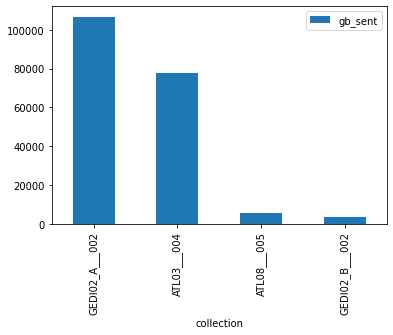

In [14]:
df[0:4].plot.bar(x='collection', y='gb_sent')

<AxesSubplot:xlabel='collection'>

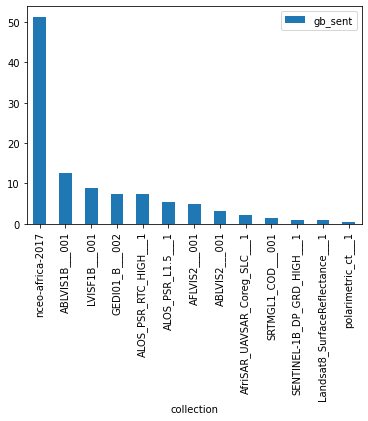

In [15]:
df[4:].plot.bar(x='collection')

## Get ESA MAAP total data requested by collection

In [4]:
esa_query_uuid = '907c98dc-7457-45af-9a8d-e57b49197d97'
query_execution_id = start_query(esa_query_uuid)
query_execution_id

Starting query SELECT
  collection, "sum"(bytessent) bytessent_sum
FROM
    (
    SELECT split_part(key, '/', 3) as collection, bytessent
    FROM "nasa_maap_data_store_access_logs_db"."logs"
    WHERE (operation = 'REST.GET.OBJECT' OR operation = 'REST.COPY.PART')
    AND date_parse(requestdatetime, '%d/%b/%Y:%H:%i:%s +0000') >= date_parse('01/Oct/2022:00:00:00 +0000', '%d/%b/%Y:%H:%i:%s +0000')
    AND remoteip LIKE '90.84.45%'
    )
GROUP BY collection
ORDER BY bytessent_sum DESC;    


'9a5a9542-8747-4aa5-a3f5-553fb788e657'

In [5]:
wait_for_finished(query_execution_id)

{'QueryExecution': {'QueryExecutionId': '9a5a9542-8747-4aa5-a3f5-553fb788e657',
  'Query': 'SELECT\n  collection, "sum"(bytessent) bytessent_sum\nFROM\n    (\n    SELECT split_part(key, \'/\', 3) as collection, bytessent\n    FROM "nasa_maap_data_store_access_logs_db"."logs"\n    WHERE (operation = \'REST.GET.OBJECT\' OR operation = \'REST.COPY.PART\')\n    AND date_parse(requestdatetime, \'%d/%b/%Y:%H:%i:%s +0000\') >= date_parse(\'01/Oct/2022:00:00:00 +0000\', \'%d/%b/%Y:%H:%i:%s +0000\')\n    AND remoteip LIKE \'90.84.45%\'\n    )\nGROUP BY collection\nORDER BY bytessent_sum DESC',
  'StatementType': 'DML',
  'ResultConfiguration': {'OutputLocation': 's3://maap-logging/athena-output/9a5a9542-8747-4aa5-a3f5-553fb788e657.csv'},
  'QueryExecutionContext': {},
  'Status': {'State': 'SUCCEEDED',
   'SubmissionDateTime': datetime.datetime(2023, 4, 8, 10, 22, 10, 869000, tzinfo=tzlocal()),
   'CompletionDateTime': datetime.datetime(2023, 4, 8, 10, 23, 20, 624000, tzinfo=tzlocal())},
  'Sta

In [9]:
results = get_execution_results(query_execution_id)
df = create_resutlts_dataframe(results)

<AxesSubplot:xlabel='collection'>

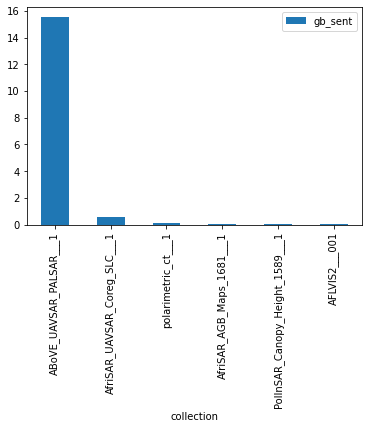

In [10]:
df.plot.bar(x='collection', y='gb_sent')